In [32]:
import db_conn
import numpy as np
import pandas as pd
import seaborn as sns 
import copy
import matplotlib.pyplot as plt

In [2]:
sql = """SELECT * FROM goal_records_rev"""
goal_records = db_conn.select_query(sql)
goal_records_pd = pd.DataFrame(goal_records)
goal_records_pd.head()

,assist,assist_player,assist_position,assist_type,goal_type,half_type,id,lost_gk,lost_team,match_id,own_goal,penalty_kick,play_time,remark,score_direction,score_player,score_position,score_team_id,score_type,touch_count
0,Y,57,1,1,0,1,2,913,25,2013-1-001,N,N,29,"전반29분 몰리나 C.KL ∩ 데얀 GA 정면 H-ST-G (득점:데얀, 도움:몰...",3,1,19,10,3,-1
1,N,,0,0,0,1,3,605,10,2013-1-001,N,N,32,"전반 32분 신진호 GAL 내 R-ST-G (득점:신진호, )왼쪽",2,2,12,25,1,-1
2,Y,57,24,2,0,2,4,913,25,2013-1-001,N,N,2,"후반 2분 몰리나 PA정면 ∼ 에스쿠데로 GAL R-ST-G (득점:에스쿠데로, 도...",1,3,18,10,1,-1
3,N,,0,0,0,2,5,605,10,2013-1-001,N,N,38,"후반 38분 이명주 PA정면 R-ST-G (득점:이명주, )오른쪽",1,4,24,25,1,-1
4,N,,0,0,0,1,6,580,19,2013-1-002,N,N,4,"전반 4분 한승엽 AKR R-ST-G (득점:한승엽, )오른쪽",1,5,28,5,1,-1


In [3]:
sql = """SELECT * FROM game_records"""
game_records = db_conn.select_query(sql)
game_records_pd = pd.DataFrame(game_records)
game_records_pd.head()

,away_team_id,away_team_score,division,game_date,game_id,game_stadium,game_time,home_team_id,home_team_score,season_year,winning_team
0,25,2,1,2013-03-02,2013-1-001,서울 월드컵,15:00,10,2,2013,0
1,5,1,1,2013-03-02,2013-1-002,울산 문수,14:45,19,2,2013,19
2,23,1,1,2013-03-02,2013-1-003,광양 전용,15:00,21,0,2013,23
3,13,2,1,2013-03-03,2013-1-004,탄천 종합,14:00,12,1,2013,13
4,2,0,1,2013-03-03,2013-1-005,인천 전용,14:00,20,0,2013,0


### 몇번째 득점이 결승골이 가장 많은가 (첫번째 득점, 두번째 등)

#### 통계 분석
* 승/패가 갈린 경우 승/패를 가르는 기점이 된 골 카운트를 결승골로 판단(3:1이면 2번째 골)
* 무승부의 경우 승/패를 가를 수 있는 골(2:2면 3번째 골)을 결승골로 판단

In [4]:
match_goal_pd = pd.DataFrame(game_records_pd, columns = ['game_id', 'home_team_score', 'away_team_score', 'home_team_id', 'away_team_id', 'winning_team', 'match_goal'])
match_goal_pd.match_goal = match_goal_pd[['home_team_score', 'away_team_score']].min(axis = 1) +1

match_goal_pd.head()

,game_id,home_team_score,away_team_score,home_team_id,away_team_id,winning_team,match_goal
0,2013-1-001,2,2,10,25,0,3
1,2013-1-002,2,1,19,5,19,2
2,2013-1-003,0,1,21,23,23,1
3,2013-1-004,1,2,12,13,13,2
4,2013-1-005,0,0,20,2,0,1


In [5]:
match_goal_statics = pd.DataFrame(match_goal_pd.groupby('match_goal').agg({'game_id': 'count'}).reset_index(), columns = ['match_goal', 'game_id', 'probs'])
match_goal_statics.columns = ['match_goal', 'counts', 'probs']
match_goal_statics.probs = match_goal_statics.counts.apply(lambda x: x / match_goal_statics[['counts']].sum().values[0])

match_goal_statics

,match_goal,counts,probs
0,1,991,0.463951
1,2,816,0.382022
2,3,283,0.132491
3,4,41,0.019195
4,5,5,0.002341


#### 결과
* 전체 2136경기 중 991경기(46.4%)가 한 골로 경기가 결정됨
* 2번째골이 결승골인 경우는 816경기(38.2%)
* 한 골 혹은 두 골로 결정나는 경우가 전체의 84.6%

#### 통계 분석
* 무승부를 제외하고 실제로 승/패가 결정난 경우만 별도 통계 분석 수행

In [6]:
match_goal_without_draw_statics = match_goal_pd[match_goal_pd.winning_team > 0]
match_goal_without_draw_statics = pd.DataFrame(match_goal_without_draw_statics.groupby('match_goal').agg({'game_id': 'count'}).reset_index(), columns = ['match_goal', 'game_id', 'probs'])

match_goal_without_draw_statics.columns = ['match_goal', 'counts', 'probs']
match_goal_without_draw_statics.probs = match_goal_without_draw_statics.counts.apply(lambda x: x / match_goal_without_draw_statics[['counts']].sum().values[0])

match_goal_without_draw_statics

,match_goal,counts,probs
0,1,789,0.516361
1,2,559,0.365838
2,3,156,0.102094
3,4,22,0.014398
4,5,2,0.001309


#### 결과
* 무승부를 제외한 1528경기 중 789경기(51.6%)가 한 골로 경기가 결정됨
* 2번째골이 결승골인 경우는 559경기(36.6%)
* 한 골 혹은 두 골로 결정나는 경우가 전체의 88.2%

### 결승골 시간대  15분씩 경기를 구분한 경우. 10분씩 구분한 경우

#### 결승골 발생 시간 구분(15분 단위)

In [7]:
match_goal_time_pd = pd.DataFrame(pd.merge(goal_records_pd[['match_id', 'id', 'score_team_id', 'half_type', 'play_time']], match_goal_pd, how='left', left_on='match_id', right_on='game_id'), columns=['match_id', 'score_team_id', 'home_team_id', 'away_team_id', 'home_team_score', 'away_team_score', 'winning_team', 'match_goal', 'half_type', 'play_time', 'time_range'])
match_goal_time_pd = match_goal_time_pd[match_goal_time_pd.winning_team > 0]

match_goal_time_pd.home_team_score = np.where(match_goal_time_pd.home_team_id == match_goal_time_pd.score_team_id, 1, 0)
match_goal_time_pd.away_team_score = np.where(match_goal_time_pd.away_team_id == match_goal_time_pd.score_team_id, 1, 0)

match_goal_time_pd.home_team_score = match_goal_time_pd.groupby(['match_id', 'score_team_id'])['home_team_score'].cumsum()
match_goal_time_pd.away_team_score = match_goal_time_pd.groupby(['match_id', 'score_team_id'])['away_team_score'].cumsum()

In [8]:
time_criteria = 15

match_goal_time_pd.time_range = np.where((match_goal_time_pd.play_time / time_criteria).astype(int) >= np.ceil(45 / time_criteria), np.ceil(45 / time_criteria)-1, (match_goal_time_pd.play_time / time_criteria).astype(int)) + 1
match_goal_time_pd.time_range = match_goal_time_pd.time_range + ((match_goal_time_pd.half_type - 1) * np.ceil(45 / time_criteria))

match_goal_time_pd.describe()

,score_team_id,home_team_id,away_team_id,home_team_score,away_team_score,winning_team,match_goal,half_type,play_time,time_range
count,4300.000000,4300.000000,4300.000000,4300.000000,4300.000000,4300.000000,4300.000000,4300.000000,4300.000000,4300.000000
mean,13.074884,12.963023,12.656512,0.945814,0.772558,13.347674,1.964884,1.603721,25.303953,3.953721
std,7.468720,7.573185,7.466350,1.130101,1.032115,7.431524,0.832535,0.489181,13.933980,1.700252
min,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,1.000000
25%,7.000000,6.000000,6.000000,0.000000,0.000000,7.000000,1.000000,1.000000,13.000000,3.000000
50%,13.000000,13.000000,12.000000,1.000000,0.000000,13.000000,2.000000,2.000000,26.000000,4.000000
75%,20.000000,20.000000,19.000000,2.000000,1.000000,20.000000,2.000000,2.000000,37.000000,6.000000
max,25.000000,25.000000,25.000000,8.000000,8.000000,25.000000,5.000000,2.000000,55.000000,6.000000


In [9]:
match_goal_time_list_pd = match_goal_time_pd[match_goal_time_pd.match_goal == match_goal_time_pd.home_team_score].append(match_goal_time_pd[match_goal_time_pd.match_goal == match_goal_time_pd.away_team_score])

match_goal_time_list_pd = pd.DataFrame(match_goal_time_list_pd.groupby('time_range').agg({'match_id': 'count'}),  columns=['match_id', 'prob'])
match_goal_time_list_pd.prob = match_goal_time_list_pd.match_id / match_goal_time_list_pd[['match_id']].sum().values[0]
match_goal_time_list_pd.columns = ['counts', 'prob']
match_goal_time_list_pd.index = ['~15분', '~30분', '~45분+@', '~60분', '~75분', '~90분+@']

match_goal_time_list_pd

,counts,prob
~15분,140,0.091623
~30분,161,0.105366
~45분+@,249,0.162958
~60분,245,0.160340
~75분,268,0.175393
~90분+@,465,0.304319


#### 결과
* 마지막 15분(후반 30분 이후)에 발생한 결승골이 전체의 30.4% 차지

#### 결승골 발생 시간 구분(10분 단위)

In [10]:
time_criteria = 10

match_goal_time_pd.time_range = np.where((match_goal_time_pd.play_time / time_criteria).astype(int) >= np.ceil(45 / time_criteria), np.ceil(45 / time_criteria)-1, (match_goal_time_pd.play_time / time_criteria).astype(int)) + 1
match_goal_time_pd.time_range = match_goal_time_pd.time_range + ((match_goal_time_pd.half_type - 1) * np.ceil(45 / time_criteria))

match_goal_time_pd.describe()

,score_team_id,home_team_id,away_team_id,home_team_score,away_team_score,winning_team,match_goal,half_type,play_time,time_range
count,4300.000000,4300.000000,4300.000000,4300.000000,4300.000000,4300.000000,4300.000000,4300.000000,4300.000000,4300.000000
mean,13.074884,12.963023,12.656512,0.945814,0.772558,13.347674,1.964884,1.603721,25.303953,6.100930
std,7.468720,7.573185,7.466350,1.130101,1.032115,7.431524,0.832535,0.489181,13.933980,2.849901
min,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,1.000000
25%,7.000000,6.000000,6.000000,0.000000,0.000000,7.000000,1.000000,1.000000,13.000000,4.000000
50%,13.000000,13.000000,12.000000,1.000000,0.000000,13.000000,2.000000,2.000000,26.000000,6.000000
75%,20.000000,20.000000,19.000000,2.000000,1.000000,20.000000,2.000000,2.000000,37.000000,9.000000
max,25.000000,25.000000,25.000000,8.000000,8.000000,25.000000,5.000000,2.000000,55.000000,10.000000


In [18]:
match_goal_time_list_pd = match_goal_time_pd[match_goal_time_pd.match_goal == match_goal_time_pd.home_team_score].append(match_goal_time_pd[match_goal_time_pd.match_goal == match_goal_time_pd.away_team_score])

match_goal_time_list_pd = pd.DataFrame(match_goal_time_list_pd.groupby('time_range').agg({'match_id': 'count'}),  columns=['match_id', 'prob'])
match_goal_time_list_pd.prob = match_goal_time_list_pd.match_id / match_goal_time_list_pd[['match_id']].sum().values[0]
match_goal_time_list_pd.columns = ['counts', 'prob']
match_goal_time_list_pd.index = ['~10분', '~20분', '~30분', '~40분', '~45분+@', '~55분', '~65분', '~75분', '~85분', '~90분+@']

match_goal_time_list_pd

,counts,prob
~10분,89,0.058246
~20분,101,0.066099
~30분,111,0.072644
~40분,122,0.079843
~45분+@,127,0.083115
~55분,152,0.099476
~65분,175,0.114529
~75분,186,0.121728
~85분,219,0.143325
~90분+@,246,0.160995


#### 결과
* 마지막 15분(후반 25분 이후)에 발생한 결승골이 전체의 30.4% 차지
    * 후반 40분 이후에 16.1%, 후반 30~40분 사이에 14.3%

### 결승골의 위치는  heatmap 활용

In [12]:
match_goal_position_pd = pd.DataFrame(pd.merge(goal_records_pd[['match_id', 'id', 'score_team_id', 'score_position', 'score_type']], match_goal_pd, how='left', left_on='match_id', right_on='game_id'), columns=['match_id', 'score_team_id', 'home_team_id', 'away_team_id', 'home_team_score', 'away_team_score', 'winning_team', 'match_goal', 'score_position', 'score_type'])
match_goal_position_pd = match_goal_position_pd[match_goal_position_pd.winning_team > 0]

match_goal_position_pd.home_team_score = np.where(match_goal_position_pd.home_team_id == match_goal_position_pd.score_team_id, 1, 0)
match_goal_position_pd.away_team_score = np.where(match_goal_position_pd.away_team_id == match_goal_position_pd.score_team_id, 1, 0)

match_goal_position_pd.home_team_score = match_goal_position_pd.groupby(['match_id', 'score_team_id'])['home_team_score'].cumsum()
match_goal_position_pd.away_team_score = match_goal_position_pd.groupby(['match_id', 'score_team_id'])['away_team_score'].cumsum()

match_goal_position_pd.head()

,match_id,score_team_id,home_team_id,away_team_id,home_team_score,away_team_score,winning_team,match_goal,score_position,score_type
4,2013-1-002,5,19,5,0,1,19,2,28,1
5,2013-1-002,19,19,5,1,0,19,2,44,3
6,2013-1-002,19,19,5,2,0,19,2,44,1
7,2013-1-003,23,21,23,0,1,23,1,20,1
8,2013-1-004,13,12,13,0,1,13,2,25,1


In [13]:
sql = """SELECT * FROM refer_codes WHERE code_type = 'goal_position' """
goal_position_code = db_conn.select_query(sql)
goal_position_code = pd.DataFrame(goal_position_code)
goal_position_code.code_id = goal_position_code.code_id.apply(pd.to_numeric)
goal_position_code.head()

,code_id,code_type,code_value
0,1,goal_position,C.KL
1,2,goal_position,E.L
2,3,goal_position,C.KR
3,4,goal_position,PAL CK
4,5,goal_position,PAL EL


In [14]:
match_goal_position_list_pd = match_goal_position_pd[match_goal_position_pd.match_goal == match_goal_position_pd.home_team_score].append(match_goal_position_pd[match_goal_position_pd.match_goal == match_goal_position_pd.away_team_score])

pd.merge(match_goal_position_list_pd.groupby('score_position').agg({'match_id': 'count'}).reset_index(), goal_position_code[['code_id', 'code_value']], how='left', left_on='score_position', right_on='code_id')[['score_position', 'code_value', 'match_id']]

,score_position,code_value,match_id
0,0,NaN,1
1,6,GAL EL,2
2,7,GAL 내 EL,5
3,8,GAR 내 EL,5
4,9,GAR EL,1
5,11,PAR CK,1
6,12,GAL 내,75
7,13,GA 정면내,103
8,14,GAR 내,93
9,15,PAL,28


In [35]:
position_map = pd.DataFrame.from_items([(0, [47, 51, 51, 96, 96, 53, 59, 54, 97, 97, 56, 56, 49]),
(1, [50, 50, 61, 64, 52, 58, 59, 60, 55, 66, 62, 57, 57]),
(2, [63, 61, 61, 64, 64, 65, 65, 65, 66, 66, 62, 62, 67]),
(3, [63, 61, 61, 69, 69, 83, 81, 82, 71, 71, 62, 62, 67]),
(4, [63, 61, 61, 69, 69, 80, 80, 80, 71, 71, 62, 62, 67]),
(5, [75, 36, 36, 36, 36, 84, 84, 84, 38, 38, 38, 38, 76]),
(6, [75, 36, 36, 36, 36, 73, 73, 73, 38, 38, 38, 38, 76]),
(7, [75, 36, 36, 36, 36, 70, 70, 70, 38, 38, 38, 38, 76]),
(8, [75, 36, 36, 36, 36, 37, 37, 37, 38, 38, 38, 38, 76]),
(9, [90, 77, 77, 77, 77, 79, 79, 79, 78, 78, 78, 78, 91]),
(10, [90, 77, 77, 77, 77, 87, 87, 87, 78, 78, 78, 78, 91]),
(11, [98, 34, 34, 34, 34, 87, 87, 87, 35, 35, 35, 35, 92]),
(12, [98, 34, 34, 34, 34, 39, 39, 39, 35, 35, 35, 35, 92]),
(13, [29, 31, 31, 31, 31, 32, 32, 32, 33, 33, 33, 33, 30]),
(14, [29, 31, 31, 31, 31, 24, 24, 24, 33, 33, 33, 33, 30]),
(15, [29, 31, 31, 31, 31, 27, 27, 27, 33, 33, 33, 33, 30]),
(16, [29, 31, 31, 31, 31, 45, 45, 45, 33, 33, 33, 33, 30]),
(17, [17, 15, 15, 23, 23, 40, 40, 40, 25, 25, 16, 16, 21]),
(18, [17, 15, 15, 23, 23, 44, 42, 43, 25, 25, 16, 16, 21]),
(19, [17, 15, 15, 18, 18, 19, 19, 19, 20, 20, 16, 16, 21]),
(20, [4, 4, 15, 18, 6, 12, 13, 14, 9, 20, 16, 11, 11]),
(21, [1, 5, 5, 94, 94, 7, 13, 8, 95, 95, 10, 10, 3])])
data = copy.deepcopy(position_map)
position_name_map = copy.deepcopy(position_map)
position_name_map = position_name_map.applymap(lambda x: goal_position_code[goal_position_code.code_id == x].code_value.values[0])
position_name_map.columns = ['goal', '-', '-', '-', '-', '-', '-', '-', '-', '-', 'center line', 'center line', '-', '-', '-', '-', '-', '-', '-', '-', '-', 'goal']
position_name_map

,goal,-,-,-,-,-,-,-,-,-,...,-,-,-,-,-,-,-,-,-,goal
0,자기측C.KL,자기측PAL CK,자기측PAL TL,자기측PAL TL,자기측PAL TL,자기측MFL TL,자기측MFL TL,자기측MFL TL,자기측MFL TL,자기측 HLL TL,...,HLL TL,MFL TL,MFL TL,MFL TL,MFL TL,PAL TL,PAL TL,PAL TL,PAL CK,C.KL
1,자기측PAL EL,자기측PAL CK,자기측PAL,자기측PAL,자기측PAL,자기측 MFL,자기측 MFL,자기측 MFL,자기측 MFL,자기측HLL,...,HLL,MFL,MFL,MFL,MFL,PAL,PAL,PAL,PAL CK,PAL EL
2,자기측PAL EL,자기측PAL,자기측PAL,자기측PAL,자기측PAL,자기측 MFL,자기측 MFL,자기측 MFL,자기측 MFL,자기측HLL,...,HLL,MFL,MFL,MFL,MFL,PAL,PAL,PAL,PAL,PAL EL
3,자기측 PAL내 EL,자기측GAL,자기측GAL,자기측PAL 내,자기측PAL 내,자기측 MFL,자기측 MFL,자기측 MFL,자기측 MFL,자기측HLL,...,HLL,MFL,MFL,MFL,MFL,PAL 내,PAL 내,GAL,GAL,PAL내 EL
4,자기측 PAL내 EL,자기측GAL EL,자기측GAL,자기측PAL 내,자기측PAL 내,자기측 MFL,자기측 MFL,자기측 MFL,자기측 MFL,자기측HLL,...,HLL,MFL,MFL,MFL,MFL,PAL 내,PAL 내,GAL,GAL EL,PAL내 EL
5,자기측GAL 내 EL,자기측GAL 내,자기측GA 정면,자기측PK좌측지점,자기측PA정면내,자기측AK내,자기측AK정면,자기측PA정면,자기측 MF정면,자기측HL정면,...,HL정면,MF정면,PA정면,AK정면,AK내,PA정면내,PK좌측지점,GA 정면,GAL 내,GAL 내 EL
6,자기측GA 정면내,자기측GA 정면내,자기측GA 정면,자기측PK지점,자기측PA정면내,자기측AK내,자기측AK정면,자기측PA정면,자기측 MF정면,자기측HL정면,...,HL정면,MF정면,PA정면,AK정면,AK내,PA정면내,PK지점,GA 정면,GA 정면내,GA 정면내
7,자기측GAR 내 EL,자기측GAR 내,자기측GA 정면,자기측PK우측지점,자기측PA정면내,자기측AK내,자기측AK정면,자기측PA정면,자기측 MF정면,자기측HL정면,...,HL정면,MF정면,PA정면,AK정면,AK내,PA정면내,PK우측지점,GA 정면,GAR 내,GAR 내 EL
8,자기측 PAR내 EL,자기측GAR EL,자기측GAR,자기측PAR 내,자기측PAR 내,자기측 MFR,자기측 MFR,자기측 MFR,자기측 MFR,자기측HLR,...,HLR,MFR,MFR,MFR,MFR,PAR 내,PAR 내,GAR,GAR EL,PAR내 EL
9,자기측 PAR내 EL,자기측GAR,자기측GAR,자기측PAR 내,자기측PAR 내,자기측 MFR,자기측 MFR,자기측 MFR,자기측 MFR,자기측HLR,...,HLR,MFR,MFR,MFR,MFR,PAR 내,PAR 내,GAR,GAR,PAR내 EL


(1528, 281, 1206, 0.18390052356020942, 0.7892670157068062)

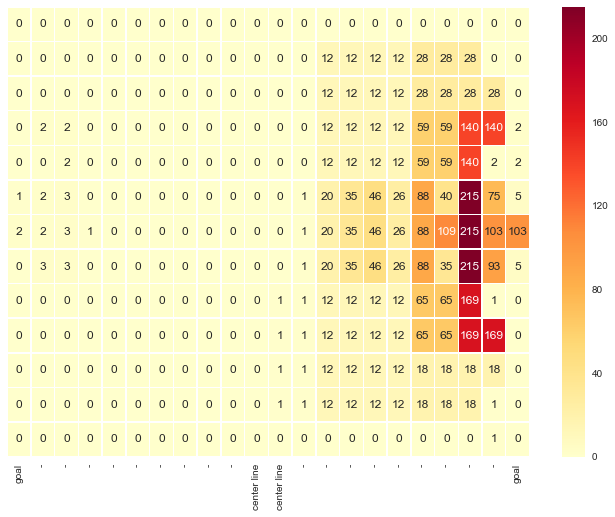

In [42]:
raw_data = pd.merge(match_goal_position_list_pd.groupby('score_position').agg({'match_id': 'count'}).reset_index(), goal_position_code[['code_id', 'code_value']], how='left', left_on='score_position', right_on='code_id')[['score_position', 'code_value', 'match_id']]

data = data * 0

for row in raw_data.itertuples(): data = data + ((position_map == row.score_position) * row.match_id)
map_data = data.apply(pd.to_numeric)
map_data.columns = ['goal', '-', '-', '-', '-', '-', '-', '-', '-', '-', 'center line', 'center line', '-', '-', '-', '-', '-', '-', '-', '-', '-', 'goal']

a4_dims = (11.7, 8.27)
fig, ax = plt.subplots(figsize=a4_dims)

sns.set()
sns.heatmap(map_data, annot=True, fmt="d", yticklabels=False, linewidths=.5, cmap="YlOrRd")

# Goal Area: 7, 8, 12, 13, 14
# Penalty Area: 6, 7, 8, 9, 12, 13, 14, 18, 19, 20, 23, 25, 40, 42, 43, 44, 94, 95
sum(raw_data.match_id), sum(raw_data[raw_data.score_position.isin([7, 8, 12, 13, 14])].match_id), sum(raw_data[raw_data.score_position.isin([6, 7, 8, 9, 12, 13, 14, 18, 19, 20, 23, 25, 40, 42, 43, 44, 94, 95])].match_id), sum(raw_data[raw_data.score_position.isin([7, 8, 12, 13, 14])].match_id) / sum(raw_data.match_id), sum(raw_data[raw_data.score_position.isin([6, 7, 8, 9, 12, 13, 14, 18, 19, 20, 23, 25, 40, 42, 43, 44, 94, 95])].match_id) / sum(raw_data.match_id)

#### 결과(5년간 결승골 발생 위치, 총 1528골)
* Goal Area 내에서 발생한 골 281골(18.4%)
* Penalty Area 내에서 발생한 골 1206골(78.9%)
* Penalty Area 내의 경우 좌측보다는 우측에서 더 많은 골
    * 좌측: 140, 59
    * 우측, 169, 65
* Penalty Area 밖의 경우 우측보다는 좌측에서 더 많은 골
    * 좌측: 28, 12
    * 우측, 18, 12

In [56]:
year_match_goal_position_list_pd = pd.DataFrame(match_goal_position_list_pd, columns=['match_id', 'score_team_id', 'home_team_id', 'away_team_id', 'home_team_score', 'away_team_score', 'winning_team', 'match_goal', 'score_position', 'score_type', 'year', 'division'])

year_match_goal_position_list_pd.year = year_match_goal_position_list_pd.match_id.str.split('-').str.get(0)
year_match_goal_position_list_pd.division = year_match_goal_position_list_pd.match_id.str.split('-').str.get(1)
year_match_goal_position_list_pd.year = year_match_goal_position_list_pd.year.apply(pd.to_numeric)
year_match_goal_position_list_pd.division = year_match_goal_position_list_pd.division.apply(pd.to_numeric)

2013 301 48 236 0.15946843853820597 0.7840531561461794
2014 287 56 220 0.1951219512195122 0.7665505226480837
2015 320 67 265 0.209375 0.828125
2016 330 63 252 0.19090909090909092 0.7636363636363637
2017 290 47 233 0.16206896551724137 0.803448275862069


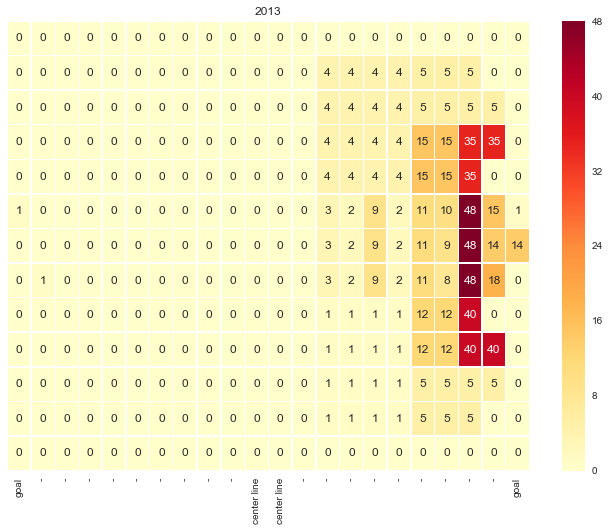

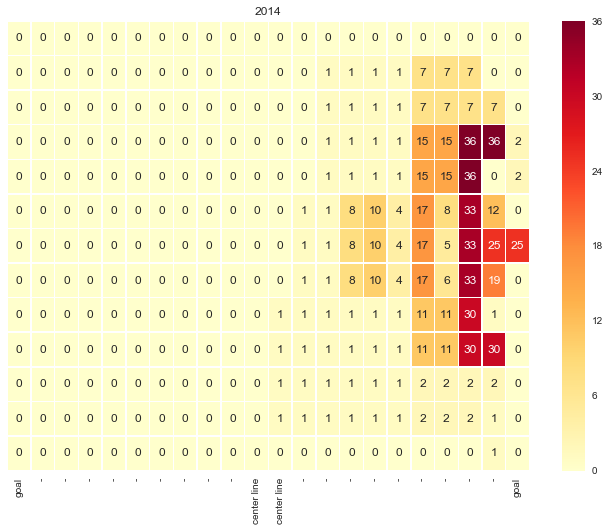

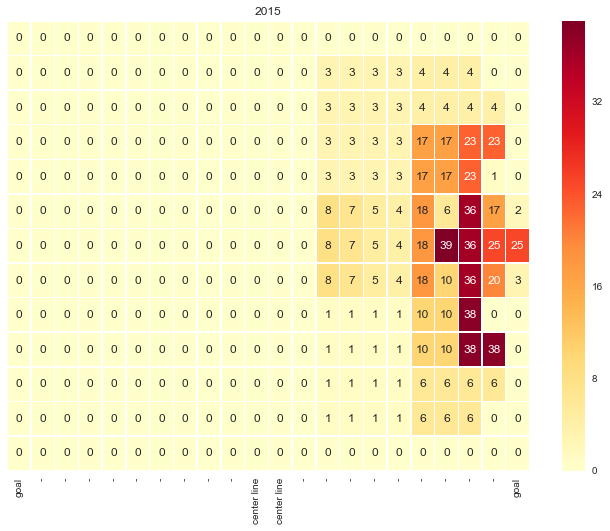

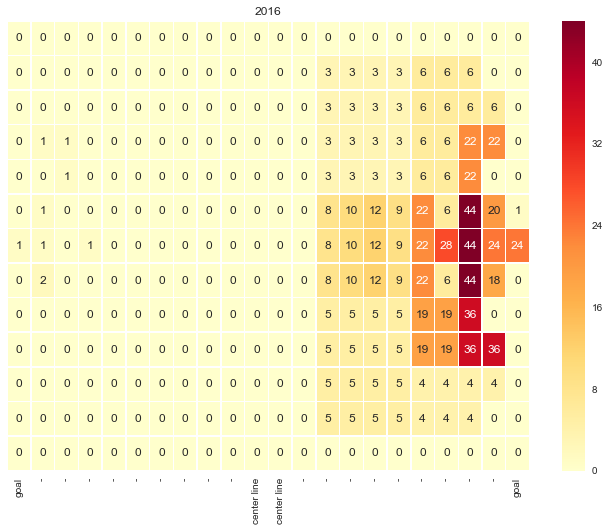

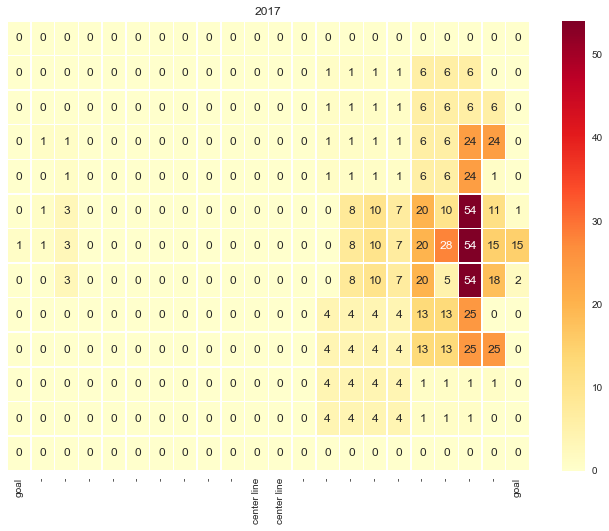

In [65]:
for year in range(2013, 2018):
    
    raw_data = pd.merge(year_match_goal_position_list_pd.groupby(['year', 'division', 'score_position']).agg({'match_id': 'count'}).reset_index(), goal_position_code[['code_id', 'code_value']], how='left', left_on='score_position', right_on='code_id')[['year', 'division', 'score_position', 'code_value', 'match_id']]
    raw_data = raw_data[raw_data.year == year]

    data = data * 0

    for row in raw_data.itertuples(): data = data + ((position_map == row.score_position) * row.match_id)
    map_data = data.apply(pd.to_numeric)
    map_data.columns = ['goal', '-', '-', '-', '-', '-', '-', '-', '-', '-', 'center line', 'center line', '-', '-', '-', '-', '-', '-', '-', '-', '-', 'goal']
    
    a4_dims = (11.7, 8.27)
    fig, ax = plt.subplots(ncols=1, figsize=a4_dims)
    plt.title(year)

    sns.set()
    sns.heatmap(map_data, annot=True, fmt="d", yticklabels=False, linewidths=.5, cmap="YlOrRd")

    # Goal Area: 7, 8, 12, 13, 14
    # Penalty Area: 6, 7, 8, 9, 12, 13, 14, 18, 19, 20, 23, 25, 40, 42, 43, 44, 94, 95
    print(year, sum(raw_data.match_id), sum(raw_data[raw_data.score_position.isin([7, 8, 12, 13, 14])].match_id), sum(raw_data[raw_data.score_position.isin([6, 7, 8, 9, 12, 13, 14, 18, 19, 20, 23, 25, 40, 42, 43, 44, 94, 95])].match_id), sum(raw_data[raw_data.score_position.isin([7, 8, 12, 13, 14])].match_id) / sum(raw_data.match_id), sum(raw_data[raw_data.score_position.isin([6, 7, 8, 9, 12, 13, 14, 18, 19, 20, 23, 25, 40, 42, 43, 44, 94, 95])].match_id) / sum(raw_data.match_id))

2013 301 48 236 0.15946843853820597 0.7840531561461794
2014 287 56 220 0.1951219512195122 0.7665505226480837
2015 320 67 265 0.209375 0.828125
2016 330 63 252 0.19090909090909092 0.7636363636363637
2017 290 47 233 0.16206896551724137 0.803448275862069

#### 결과(연도별)
* 2013년
    * 301골 중 Goal Area 내에서 발생한 골이 48골 (15.9%)
    * 301골 중 Penalty Area 내에서 발생한 골이 236골 (78.4%)
* 2014년
    * 287골 중 Goal Area 내에서 발생한 골이 56골 (19.5%)
    * 287골 중 Penalty Area 내에서 발생한 골이 220골 (76.7%)
* 2015년
    * 320골 중 Goal Area 내에서 발생한 골이 67골 (20.9%)
    * 320골 중 Penalty Area 내에서 발생한 골이 265골 (82.8%)
* 2016년
    * 330골 중 Goal Area 내에서 발생한 골이 63골 (19.1%)
    * 330골 중 Penalty Area 내에서 발생한 골이 252골 (76.4%)
* 2017년
    * 290골 중 Goal Area 내에서 발생한 골이 47골 (16.2%)
    * 290골 중 Penalty Area 내에서 발생한 골이 233골 (80.3%)

### 신체 부위 구분 가능하면  헤딩골, 슈팅, 등

In [15]:
sql = """SELECT * FROM refer_codes WHERE code_type = 'goal_type' """
goal_type_code = db_conn.select_query(sql)
goal_type_code = pd.DataFrame(goal_type_code)
goal_type_code.code_id = goal_type_code.code_id.apply(pd.to_numeric)
goal_type_code

,code_id,code_type,code_value
0,1,goal_type,R-ST-G (오른발 골)
1,2,goal_type,L-ST-G (왼발 골)
2,3,goal_type,H-ST-G (헤딩 골)
3,4,goal_type,R자책골 (오른발 자책골)
4,5,goal_type,L자책골 (왼발 자책골)
5,6,goal_type,H자책골 (헤딩 자책골)
6,7,goal_type,자책골
7,8,goal_type,몸맞고 골
8,9,goal_type,PK-R-G (PK 오른발 골)
9,10,goal_type,PK-L-G (PK 왼발 골)


In [16]:
pd.merge(match_goal_position_list_pd.groupby('score_type').agg({'match_id': 'count'}).reset_index(), goal_type_code[['code_id', 'code_value']], how='left', left_on='score_type', right_on='code_id')[['score_type', 'code_value', 'match_id']]

,score_type,code_value,match_id
0,1,R-ST-G (오른발 골),765
1,2,L-ST-G (왼발 골),350
2,3,H-ST-G (헤딩 골),268
3,4,R자책골 (오른발 자책골),11
4,5,L자책골 (왼발 자책골),6
5,6,H자책골 (헤딩 자책골),6
6,7,자책골,7
7,8,몸맞고 골,3
8,9,PK-R-G (PK 오른발 골),95
9,10,PK-L-G (PK 왼발 골),17


#### 결과
* 일반 득점의 경우 절반 이상이 오른발 골(765골 / 1383골, 55.3%)
* PK의 경우 압도적으로 오른발 골이 많음(95골 / 112골, 84.8%)